In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import animation
import imageio_ffmpeg
from statsbombpy import sb
from mplsoccer import Pitch
import json
from pathlib import Path
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


from auxiliar_functions import *

### Pass Risk Measure – Concept
The goal is to approximate StatsBomb’s proprietary pass difficulty metrics (e.g. xPass, OBV) with a simplified model. The idea behind pass risk definition is the likelihood a pass will *fail*, given its contextual environment. Contextual factors considered are pass length and height, angle, bypassed opponents, field zone (for both origin and destination), and pressure (by nearest-defender distance).


In [2]:
data_dir = Path("data/italy_euro2020")
matches_file = data_dir / "matches/55/43.json"

In [3]:
# %run download_italy_euro2020_data.py

In [4]:
# Build files summary
matches = json.loads(matches_file.read_text(encoding="utf-8"))
df = pd.json_normalize(matches)

cols = [
    "match_id",
    "match_date",
    "competition_stage.name",
    "home_team.home_team_name",
    "away_team.away_team_name",
]
df = df[cols].rename(columns={  "competition_stage.name": "stage",
                                "home_team.home_team_name": "home",
                                "away_team.away_team_name": "away",
                                })


df = df[(df["home"] == "Italy") | (df["away"] == "Italy")].sort_values("match_date").reset_index(drop=True)
match_ids = df["match_id"].tolist()

summary_rows = []
for id in match_ids:
    event = file_exists(data_dir / "events" / f"{id}.json")
    lineup = file_exists(data_dir / "lineups" / f"{id}.json")
    fr_path = data_dir / "three-sixty" / f"{id}.json"
    fr_exists = file_exists(fr_path)
    n_frames = count_freeze_frames(id, data_dir) if fr_exists else 0
    summary_rows.append({
        "match_id": id,
        "events.json": event,
        "lineups.json": lineup,
        "three-sixty.json": fr_exists,
        "frames_count": n_frames,
    })

# Merge into the main DataFrame
availability = pd.DataFrame(summary_rows)
df = df.merge(availability, on="match_id")

print("Italy Euro 2020 matches data availability summary:")
display(df)

Italy Euro 2020 matches data availability summary:


,match_id,match_date,stage,home,away,events.json,lineups.json,three-sixty.json,frames_count
0,3788741,2021-06-11,Group Stage,Turkey,Italy,True,True,True,3370
1,3788754,2021-06-16,Group Stage,Italy,Switzerland,True,True,True,3423
2,3788766,2021-06-20,Group Stage,Italy,Wales,True,True,True,2800
3,3794685,2021-06-26,Round of 16,Italy,Austria,True,True,True,4456
4,3795107,2021-07-02,Quarter-finals,Belgium,Italy,True,True,True,2965
5,3795220,2021-07-06,Semi-finals,Italy,Spain,True,True,True,4247
6,3795506,2021-07-11,Final,Italy,England,True,True,True,4303


**Data preprocessing**

Filtering and feature engineering steps necessary to obtain relevant features for this analysis.

In [8]:
features = [
        "id", "minute", "second", "time", "team", "player_name", "sx", "sy", "recipient", "ex", "ey",
        "dx", "dy", "length", "angle", "direction", "is_progressive", "height",
        "is_cross", "is_through", "zone_origin", "zone_dest", "is_complete"
    ]

pressure_thr = 3.5          # in meters
bypass_margin_thr = 2.0     # in meters

pass_events = []
lineups_list = []
frames_list = []
for id in match_ids:
    ev = load_events(id, data_dir)
    lineup = load_lineups(id, data_dir)
    frames = load_360(id, data_dir)
    pass_features = pass_features_from_events(ev, features)
    pass_features["match_id"] = id
    pass_events.append(pass_features)
    lineups_list.append(lineup)
    frames_list.append(frames)


df_pass = pd.concat(pass_events, ignore_index=True).reset_index(drop=True)
df_lineups = pd.concat(lineups_list, ignore_index=True).reset_index(drop=True)
df_frames = pd.concat(frames_list, ignore_index=True).reset_index(drop=True)

df_pass = df_pass.merge(df[["match_id", "home", "away", "stage"]], on="match_id", how="left")
df_pass = df_pass.merge(df_lineups[['match_id', 'player_name', 'jersey_number']], on=['match_id', 'player_name'], how='left')
df_pass = df_pass.merge(df_lineups[['match_id', 'player_name', 'jersey_number']], left_on=['match_id', 'recipient'], right_on=['match_id', 'player_name'], how='left')

df_frames = df_frames.merge(df_pass[['id','sx','sy','ex','ey']], left_on='event_index', right_on='id', how='right')
df_360 = (
    df_frames.groupby("event_index", sort=False)
            .apply(pressure_metrics, pressure_thr=pressure_thr, bypass_margin_thr=bypass_margin_thr)
            .reset_index()
            .rename(columns={"event_index": "id"})
)
df_pass = df_pass.merge(df_360, on="id", how="left")
df_pass['passer_pressure'] = df_pass['passer_pressure'].fillna(0).astype(int)
df_pass['receiver_pressure'] = df_pass['receiver_pressure'].fillna(0).astype(int)
df_pass['bypassed_opponents'] = df_pass['bypassed_opponents'].fillna(0).astype(int)


df_pass = df_pass.rename(columns={  "player_name_x": "player_name",
                                    "jersey_number_x": "jersey_number",
                                    "jersey_number_y": "jersey_number_receiver"})
df_pass = df_pass.drop(columns={'player_name_y'})
df_pass["jersey_number"] = df_pass["jersey_number"].astype(int)
df_pass["jersey_number_receiver"] = df_pass["jersey_number_receiver"].fillna(0).astype(int)


display(df_pass.head(20))

,id,minute,second,time,team,player_name,sx,sy,recipient,ex,ey,dx,dy,length,angle,direction,is_progressive,height,is_cross,is_through,zone_origin,zone_dest,is_complete,match_id,home,away,stage,jersey_number,jersey_number_receiver,passer_pressure,passer_pressure_dist,receiver_pressure,receiver_pressure_dist,bypassed_opponents
0,5c888f58-fe77-459b-ab3b-a2fa5fb8ab16,0,0,00:00,Turkey,Burak Yılmaz,60.0,40.0,Caglar Söyüncü,32.5,28.8,-27.5,-11.2,29.693265,-2.754832,backward,False,Ground Pass,False,False,middle,defensive,True,3788741,Turkey,Italy,Group Stage,17,4,0,8.700299,0,11.600015,2
1,84b9b798-0fbe-45bc-a4bf-3621959f29ce,0,4,00:04,Turkey,Caglar Söyüncü,36.2,30.4,Kenan Karaman,70.7,75.8,34.5,45.4,57.021136,0.920982,forward,True,High Pass,False,False,defensive,middle,True,3788741,Turkey,Italy,Group Stage,4,9,0,5.362913,0,30.067519,1
2,089acaca-894c-4b14-96a5-c845088af8ad,0,12,00:12,Italy,Leonardo Spinazzola,43.1,0.1,Giorgio Chiellini,15.8,7.5,-27.3,7.4,28.285155,2.876891,backward,False,Low Pass,False,False,middle,defensive,True,3788741,Turkey,Italy,Group Stage,4,3,0,9.050701,0,22.591962,0
3,bfcfd5ad-1dda-44c9-9f3d-9b33b59983a6,0,16,00:16,Italy,Giorgio Chiellini,3.3,12.7,Gianluigi Donnarumma,7.9,36.2,4.6,23.5,23.945981,1.377496,forward,False,Ground Pass,False,False,defensive,defensive,True,3788741,Turkey,Italy,Group Stage,3,21,0,34.110872,0,29.149841,0
4,14604dfa-65b1-40c0-a11e-7c6b037806c0,0,20,00:20,Italy,Gianluigi Donnarumma,9.1,38.9,Leonardo Bonucci,19.7,47.9,10.6,9.0,13.905395,0.703946,forward,True,Ground Pass,False,False,defensive,defensive,True,3788741,Turkey,Italy,Group Stage,21,19,0,29.491182,0,20.856108,0
5,2b3361c2-de34-4eea-bcd8-1815de59a72d,0,24,00:24,Italy,Leonardo Bonucci,28.8,49.9,Giorgio Chiellini,31.8,23.3,3.0,-26.6,26.768638,-1.458489,forward,False,Ground Pass,False,False,defensive,defensive,True,3788741,Turkey,Italy,Group Stage,19,3,0,14.026175,0,21.152154,0
6,e8da1a83-3012-43f1-9dc9-94dbf9de6e24,0,27,00:27,Italy,Giorgio Chiellini,37.9,20.2,Leonardo Bonucci,34.5,40.0,-3.4,19.8,20.089798,1.740855,backward,False,Ground Pass,False,False,defensive,defensive,True,3788741,Turkey,Italy,Group Stage,3,19,0,13.971074,0,12.922600,0
7,73e19e02-1f83-4d0d-a468-bfa237c7943e,0,31,00:31,Italy,Leonardo Bonucci,34.7,40.3,Giorgio Chiellini,44.6,16.5,9.9,-23.8,25.776928,-1.176602,forward,False,Ground Pass,False,False,defensive,middle,True,3788741,Turkey,Italy,Group Stage,19,3,0,4.773311,0,13.441041,0
8,bb2248eb-199d-45db-aeda-371032d1f834,0,35,00:35,Italy,Giorgio Chiellini,47.9,10.5,Lorenzo Insigne,99.8,15.1,51.9,4.6,52.103455,0.088401,forward,True,High Pass,False,False,middle,attacking,False,3788741,Turkey,Italy,Group Stage,3,10,0,6.580902,0,38.259838,0
9,12cd9fe9-f3d3-4ef6-b961-a490a3de2877,0,42,00:42,Italy,Leonardo Spinazzola,91.1,0.1,Manuel Locatelli,96.6,7.0,5.5,6.9,8.823831,0.897825,forward,False,Low Pass,False,False,attacking,attacking,True,3788741,Turkey,Italy,Group Stage,4,5,0,NaN,0,NaN,0


**Pass Map Visuals Preparation**

The idea is to build pass sequences and risk for both teams in Euro2020 final game.

In [6]:
n_passes_in_viz = 3
pitch_length = 120
pitch_width = 80

team_color = {
    'italy': '#1f77b4',
    'opponent': "#ffffff",
}

pass_outcome_color = {
    'successful': "#32BE32",
    'fail': "#fa4e4e",
}


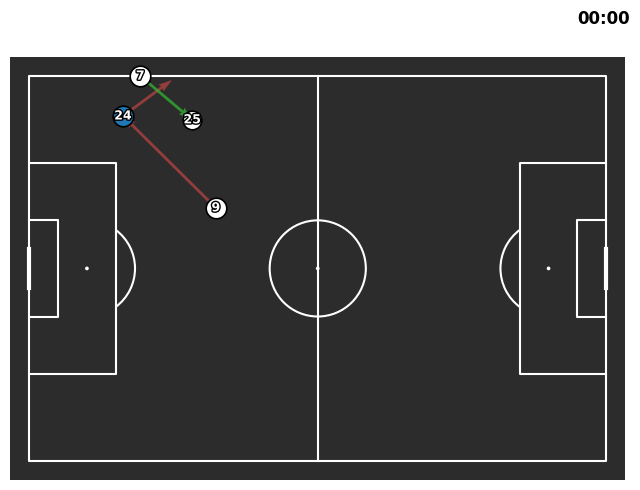

In [9]:
# visualize pass events
df_final = df_pass[df_pass["stage"]=="Final"]

#flip away team locations
is_away = df_final['team']!=df_final['home']
df_final.loc[is_away, ["sx","ex"]] = pitch_length - df_final.loc[is_away, ["sx","ex"]]
df_final.loc[is_away, ["sy","ey"]] = pitch_width - df_final.loc[is_away, ["sy","ey"]]

df_final = df_final.sort_values(['minute','second']).reset_index(drop=True)

pitch = Pitch(pitch_type="statsbomb", pitch_color="#2C2C2C", line_color='white', linewidth=1.5)
fig, ax = pitch.draw(figsize=(7,5))
time_text = ax.text(
    pitch_length+5, -10, "",
    ha="right", va="bottom",
    fontsize=12, color="black", weight="bold"
)

visualize_frames = []
player_markers = {}

def animate(i):

    if i==0:
        time_text.set_text('00:00')
        return ax,

    row = df_final.iloc[i-1]
    time_text.set_text(row['time'])
    pass_color = pass_outcome_color['successful'] if row['is_complete']==True else pass_outcome_color['fail']
    player_color = team_color['italy'] if row['team']=='Italy' else team_color['opponent']

    frame = []

    #draw pass
    pass_arrow = pitch.arrows(row['sx'], row['sy'], row['ex'], row['ey'],
                        color=pass_color, ax=ax, 
                        alpha=0.7 if bool(row["is_complete"]) else 0.5,
                        linestyle="-" if bool(row["is_complete"]) else "--",
                        width=2)
    frame.append(pass_arrow)

    #draw action player
    player_circle = draw_numbered_circle(ax,
                            x=row["sx"], y=row["sy"],
                            number=row["jersey_number"],
                            facecolor=player_color)
    frame.extend(player_circle)
    update_player_markers(player_markers=player_markers, 
                          player_name=row['player_name'], 
                          x=row['sx'], 
                          y=row['sy'], 
                          circle=player_circle, 
                          number=row['jersey_number'])
    
    #draw receiver player
    if row['is_complete']==True:
        receiver_circle = draw_numbered_circle(ax, row["ex"], row["ey"],
                                    number=row["jersey_number_receiver"],
                                    facecolor=player_color, size=180)
        frame.extend(receiver_circle)
        update_player_markers(player_markers=player_markers, 
                              player_name=row["recipient"], 
                              x=row["ex"], 
                              y=row["ey"], 
                              circle=receiver_circle, 
                              number=row["jersey_number_receiver"])
    
    visualize_frames.append(frame)
    if len(visualize_frames) > n_passes_in_viz:
        old = visualize_frames.pop(0)
        for art in old:
            try:
                art.remove()
            except Exception:
                pass


    return ax,


ani = animation.FuncAnimation(fig, animate,
                              frames=len(df_final),
                              interval=80,
                              blit=False,
                              repeat=False)

# save file
ffmpeg_path = imageio_ffmpeg.get_ffmpeg_exe()
mpl.rcParams["animation.ffmpeg_path"] = ffmpeg_path
writer = animation.FFMpegWriter(fps=3, bitrate=1800)
ani.save('euro2020_final_pass_animation.mp4', writer=writer)